# First training using the simple negation data

In [1]:
# all imports
import numpy as np
import pandas as pd
import torch
from torchtext import data
import torch.optim as optim

import os
import inspect
import sys
import itertools

almost_current = os.path.abspath(inspect.getfile(inspect.currentframe()))
currentdir = os.path.dirname(almost_current)
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

from plots.functions  import plot_confusion_matrix, plot_histogram_from_labels
from text_processing.functions import simple_pre_process_text_df, simple_pre_process_text

% matplotlib inline

In [2]:
train_data_path = os.path.join(parentdir,
                               "text_generator",
                                "b1_train.csv")

test_data_path = os.path.join(parentdir,
                              "text_generator",
                              "b1_test.csv")

In [3]:
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [4]:
train_data.head()

,sentence1,sentence2,label
0,Winston is lively,Brooklyn is not nice,0
1,Reynold is witty,Quanda is not thankful,0
2,Hazel is brave,Charity is not witty,0
3,Sutcliff is silly,Lyle is not ambitious,0
4,Banner is ambitious,Banner is not ambitious,1


In [5]:
test_data.head()

,sentence1,sentence2,label
0,Radella is jolly,Radella is not jolly,1
1,Harris is proud,Westcott is not ambitious,0
2,Ellery is obedient,Josie is not delightful,0
3,Win is brave,Esmond is not eager,0
4,Everly is eager,Osborn is not happy,0


## Putting the sentences together

In [6]:
train_data["text"] = train_data["sentence1"]  + ", " + train_data["sentence2"]
test_data["text"] = test_data["sentence1"]  + ", " + test_data["sentence2"]
train_data.drop(["sentence1", "sentence2"], axis=1, inplace=True)
test_data.drop(["sentence1", "sentence2"], axis=1, inplace=True)
train_data = train_data[["text", "label"]]
test_data = test_data[["text", "label"]] 

In [7]:
train_data.head()

,text,label
0,"Winston is lively, Brooklyn is not nice",0
1,"Reynold is witty, Quanda is not thankful",0
2,"Hazel is brave, Charity is not witty",0
3,"Sutcliff is silly, Lyle is not ambitious",0
4,"Banner is ambitious, Banner is not ambitious",1


In [8]:
test_data.head()

,text,label
0,"Radella is jolly, Radella is not jolly",1
1,"Harris is proud, Westcott is not ambitious",0
2,"Ellery is obedient, Josie is not delightful",0
3,"Win is brave, Esmond is not eager",0
4,"Everly is eager, Osborn is not happy",0


In [9]:
labels_legend = ['no', 'yes']
anwser2int = {'no':0, 'yes':1}
int2anwser = {i[1]: i[0] for i in anwser2int.items()}
train_labels = [int2anwser[i] for i in train_data["label"].values]
test_labels = [int2anwser[i] for i in train_data["label"].values]

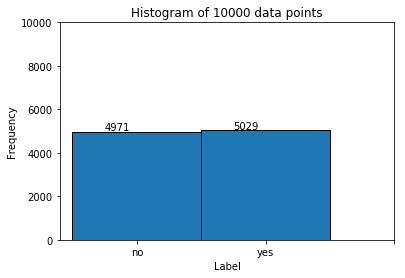

In [10]:
plot_histogram_from_labels(train_labels, labels_legend, "train data")

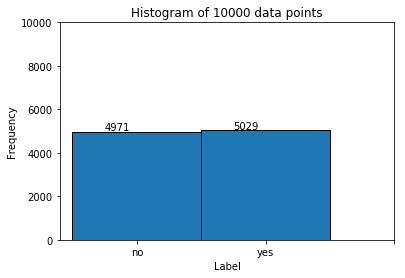

In [11]:
plot_histogram_from_labels(test_labels, labels_legend, "train data")

### Applying preprocessing function

In [12]:
print("\nAFTER using the function simple_pre_process_text_df \n")
simple_pre_process_text_df(train_data)
simple_pre_process_text_df(test_data)
print(train_data["text"].values[2])
print()
print(train_data["text"].values[3])
print()
print(train_data["text"].values[4])


AFTER using the function simple_pre_process_text_df 

hazel is brave charity is not witty

sutcliff is silly lyle is not ambitious

banner is ambitious banner is not ambitious


## Saving the new version of the data in a csv

In [13]:
train_data_path = os.path.join(parentdir,
                               "text_generator",
                                "b1_train_processed.csv")

test_data_path = os.path.join(parentdir,
                              "text_generator",
                              "b1_test_processed.csv")


train_data.to_csv(train_data_path, header=False, index=False)
test_data.to_csv(test_data_path, header=False, index=False)

### Starting with torch

We use the`data.Field` to hold all the text data:

> Field class models common text processing datatypes that can be represented
by tensors.  It holds a Vocab object that defines the set of possible values
for elements of the field and their corresponding numerical representations.
The Field object also holds other parameters relating to how a datatype
should be numericalized, such as a tokenization method and the kind of
Tensor that should be produced.

and the class `data.LabelField` to hold the labels:

> A label field is a shallow wrapper around a standard field designed to hold labels
for a classification task. Its only use is to set the unk_token and sequential to `None` by default.

In [14]:
TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(tensor_type=torch.FloatTensor)

And so we can create a dataset by using the class `data.TabularDataset` and the data in the `csv` format

In [15]:
train = data.TabularDataset(path=train_data_path,
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

test = data.TabularDataset(path=test_data_path,
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

Creating the train-valid split (80$\%$ for training data and 20$\%$ for validation data)

In [16]:
train, valid = train.split(0.8)

In [17]:
print('len(train):', len(train))
print('len(valid):', len(valid))
print('len(test):', len(test))

len(train): 8000
len(valid): 2000
len(test): 1000


Constructing the Vocabulary, using at maximun 25000 words

In [18]:
TEXT.build_vocab(train, max_size=25000)
LABEL.build_vocab(train)

In [19]:
print('len(TEXT.vocab):', len(TEXT.vocab))
print('len(LABEL.vocab):', len(LABEL.vocab))

len(TEXT.vocab): 1334
len(LABEL.vocab): 2


Printing the 20 most frequent words

In [20]:
print(TEXT.vocab.freqs.most_common(20))

[('is', 16000), ('not', 8000), ('victorious', 769), ('gentle', 749), ('brave', 738), ('thankful', 736), ('ambitious', 730), ('polite', 718), ('calm', 717), ('obedient', 715), ('delightful', 706), ('lively', 705), ('eager', 701), ('nice', 691), ('kind', 679), ('agreeable', 676), ('zealous', 676), ('proud', 673), ('jolly', 672), ('wonderful', 671)]


- `.itos` is the `int2str` method from the object `TEXT.vocab` 
- `.stoi` is the `str2int` method from the object `TEXT.vocab` 

In [21]:
print("TEXT.vocab.itos")
print("word", "index")

for i, word in enumerate(TEXT.vocab.itos[:10]):
    print(word, i)


print()
print("TEXT.vocab.stoi")
print("word", "index")
for word in "i love trump".split():
    print(word, TEXT.vocab.stoi[word])

TEXT.vocab.itos
word index
<unk> 0
<pad> 1
is 2
not 3
victorious 4
gentle 5
brave 6
thankful 7
ambitious 8
polite 9

TEXT.vocab.stoi
word index
i 0
love 1082
trump 0


In [22]:
class RNNConfig(object):
    """
    Holds logistic regression model hyperparams.
    
    :param height: image height
    :type heights: int
    :param width: image width
    :type width: int
    :param channels: image channels
    :type channels: int
    :param batch_size: batch size for training
    :type batch_size: int
    :param epochs: number of epochs
    :type epochs: int
    :param save_step: when step % save_step == 0, the model
                      parameters are saved.
    :type save_step: int
    :param learning_rate: learning rate for the optimizer
    :type learning_rate: float
    :param momentum: momentum param
    :type momentum: float
    """
    def __init__(self,
                 vocab_size=25000,
                 batch_size=32,
                 embedding_dim=100,
                 rnn_dim=100,
                 output_dim=2,
                 epochs=10,
                 learning_rate=0.05,
                 momentum=0.1):
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.embedding_dim = embedding_dim
        self.rnn_dim = rnn_dim
        self.output_dim = output_dim
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        

    def __str__(self):
        """
        Get all attributs values.
        :return: all hyperparams as a string
        :rtype: str
        """
        status = "vocab_size = {}\n".format(self.vocab_size)
        status += "batch_size = {}\n".format(self.batch_size)
        status += "embedding_dim = {}\n".format(self.embedding_dim)
        status += "rnn_dim = {}\n".format(self.rnn_dim)
        status += "output_dim = {}\n".format(self.output_dim)
        status += "epochs = {}\n".format(self.epochs)
        status += "learning_rate = {}\n".format(self.learning_rate)
        status += "momentum = {}\n".format(self.momentum)
        return status

Hyperparams

In [23]:
config = RNNConfig(vocab_size=len(TEXT.vocab),
                   output_dim=len(LABEL.vocab))
print(config)

vocab_size = 1334
batch_size = 32
embedding_dim = 100
rnn_dim = 100
output_dim = 2
epochs = 10
learning_rate = 0.05
momentum = 0.1



To define an iterator that batches examples of similar lengths together we use the class `data.BucketIterator`. 


In [24]:
class DataHolder():
    """
    Class to store all data using the data.BucketIterator class.

    """
    def __init__(self,
                 config,
                 train,
                 valid,
                 test):        
        self.train_iter = data.BucketIterator(train, batch_size=config.batch_size, repeat=False)
        self.valid_iter = data.BucketIterator(valid, batch_size=config.batch_size, repeat=False)
        self.test_iter = data.BucketIterator(test, batch_size=len(test), repeat=False)
        
        
b1data = DataHolder(config, train, valid, test) 

We can see some batch examples, here we should remember that the batch shape is `[sent len, batch size]`

In [25]:
batch = next(iter(b1data.train_iter))
print("batch.text.shape = {}".format(batch.text.shape))
print("batch.text.type = {}\n".format(batch.text.type()))

print("batch.label.shape = {}".format(batch.label.shape))
print("batch.label.type = {}\n".format(batch.label.type()))
batch_t = batch.text.transpose(0, 1)
for example in batch_t:
    print()
    print([TEXT.vocab.itos[i] for i in example], end=" ")

batch.text.shape = torch.Size([7, 32])
batch.text.type = torch.LongTensor

batch.label.shape = torch.Size([32])
batch.label.type = torch.FloatTensor


['lyman', 'is', 'victorious', 'kenley', 'is', 'not', 'proud'] 
['quince', 'is', 'wonderful', 'araminta', 'is', 'not', 'jolly'] 
['haylee', 'is', 'jolly', 'haylee', 'is', 'not', 'jolly'] 
['fisk', 'is', 'calm', 'billy', 'is', 'not', 'wonderful'] 
['christian', 'is', 'ambitious', 'christian', 'is', 'not', 'ambitious'] 
['tamsin', 'is', 'proud', 'tamsin', 'is', 'not', 'proud'] 
['ludlow', 'is', 'kind', 'wren', 'is', 'not', 'wonderful'] 
['bradbury', 'is', 'lively', 'oberon', 'is', 'not', 'victorious'] 
['ivory', 'is', 'calm', 'ivory', 'is', 'not', 'calm'] 
['miles', 'is', 'brave', 'jean', 'is', 'not', 'happy'] 
['ivy', 'is', 'aggressive', 'ivy', 'is', 'not', 'aggressive'] 
['nick', 'is', 'lively', 'nick', 'is', 'not', 'lively'] 
['kendall', 'is', 'polite', 'kendall', 'is', 'not', 'polite'] 
['avery', 'is', 'zealous', 'avery', 'is', 'not', '

Here we will define the RNN model using the `nn.module` class.

In [26]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.embedding = nn.Embedding(config.vocab_size, config.embedding_dim)
        self.rnn = nn.RNN(config.embedding_dim, config.rnn_dim)
        self.fc = nn.Linear(config.rnn_dim, config.output_dim)
        
    def forward(self, x):

        #x = [sent len, batch size]
        
        embedded = self.embedding(x)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        return self.fc(hidden.squeeze(0))

    def predict(self, x):
        out = self.forward(x)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

    def evaluate_bach(self, batch):
        prediction = model.predict(batch.text)
        labels = batch.label.type('torch.LongTensor')
        correct = torch.sum(torch.eq(prediction, labels)).float()
        accuracy = float(correct/labels.shape[0])
        return accuracy, prediction, labels
        


In [27]:
model = RNN(config)

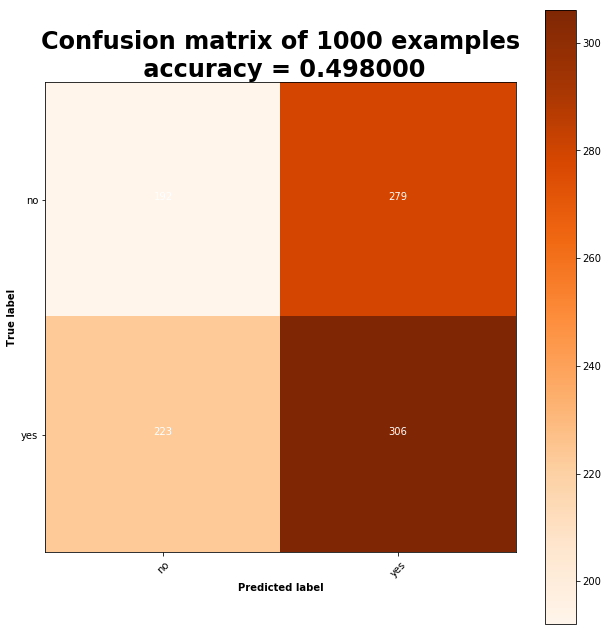

In [28]:
test_bach = next(iter(b1data.test_iter))
_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="rnn_confusion_matrix_b1.png",
                      classes=labels_legend)

training function

In [29]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        logits = model(batch.text)
        label = batch.label.type("torch.LongTensor")
        loss = criterion(logits, label)
        acc, _, _ = model.evaluate_bach(batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc

    mean_loss = epoch_loss / len(iterator)
    mean_acc = epoch_acc / len(iterator)
        
    return mean_loss, mean_acc


def get_valid_loss(model, valid_iter, criterion):
    batch = next(iter(valid_iter))
    model.eval()
    logits = model(batch.text)
    label = batch.label.type("torch.LongTensor")
    loss = criterion(logits, label)
    return loss

def training_loop_text_classification(model, config, dataholder, model_path, verbose=True):
    """
    Train a model for text classification

    :param model: RNN classification model
    :type model: 
    :param config: image classification model
    :type config: LogisticRegression or DFN
    :param dataholder: data
    :type dataholder: DataHolder or DataHolderGentle
    :param model_path: path to save model params
    :type model_path: str
    :param verbose: param to control print
    :type verbose: bool
    """
    optimizer = optim.SGD(model.parameters(),
                          lr=config.learning_rate,
                          momentum=config.momentum)
    
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = criterion.to(device)
    train_iter = dataholder.train_iter
    valid_iter = dataholder.valid_iter
    
    best_valid_loss = float("inf")
    
    for epoch in range(config.epochs):
        print("epoch = ({}/{})".format(epoch + 1, config.epochs))
        train_loss, train_acc = train(model, train_iter, optimizer, criterion)
        valid_loss = get_valid_loss(model,valid_iter, criterion)
        msg = "\ntrain_loss = {:.3f} | valid_loss = {:.3f}".format(float(train_loss),float(valid_loss))
        if float(valid_loss) < best_valid_loss:
            torch.save(model.state_dict(), model_path)
            best_valid_loss = float(valid_loss)
        if verbose:
            print(msg)
            print("train_acc = {}\n".format(train_acc))    

In [30]:
training_loop_text_classification(model, config, b1data, "rnn.pkl")

epoch = (1/10)

train_loss = 0.704 | valid_loss = 0.719
train_acc = 0.491

epoch = (2/10)

train_loss = 0.699 | valid_loss = 0.720
train_acc = 0.51475

epoch = (3/10)

train_loss = 0.697 | valid_loss = 0.700
train_acc = 0.512125

epoch = (4/10)

train_loss = 0.690 | valid_loss = 0.671
train_acc = 0.5375

epoch = (5/10)

train_loss = 0.561 | valid_loss = 0.378
train_acc = 0.735

epoch = (6/10)

train_loss = 0.341 | valid_loss = 0.303
train_acc = 0.878

epoch = (7/10)

train_loss = 0.212 | valid_loss = 0.172
train_acc = 0.933875

epoch = (8/10)

train_loss = 0.144 | valid_loss = 0.285
train_acc = 0.956875

epoch = (9/10)

train_loss = 0.098 | valid_loss = 0.175
train_acc = 0.97275

epoch = (10/10)

train_loss = 0.063 | valid_loss = 0.083
train_acc = 0.984625



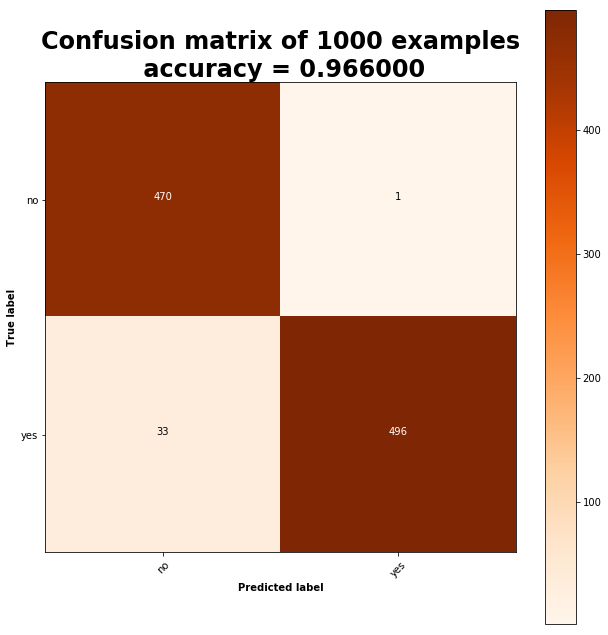

In [31]:
model = RNN(config)
model.load_state_dict(torch.load('rnn.pkl'))
_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="rnn_confusion_matrix.png",
                      classes=labels_legend)

In [34]:
t1 = "Reynold is brave, Reynold is not brave"
t2 = "Reynold is brave, Reynold is not hot"
t3 = "Brooklyn is calm, Brooklyn is not calm"
t4 = "Brooklyn is calm, Brooklyn is not brave"
t5 = "Miles is gentle, Miles is not gentle"
t6 = "Miles is brave, Miles is not gentle"
examples = [t1,t2,t3,t4,t5,t6]

In [35]:
for example in examples:
    print()
    print(example)
    text = simple_pre_process_text(example)
    text_as_int = [TEXT.vocab.stoi[word] for word in text.split(" ")]
    text_as_tensor = torch.Tensor(text_as_int).type('torch.LongTensor')
    text_as_tensor = text_as_tensor.view((1, text_as_tensor.shape[0]))
    text_as_tensor = text_as_tensor.t()  # putting in the format [sent len, batch size]
    pred = int(model.predict(text_as_tensor))
    print(LABEL.vocab.itos[pred])


Reynold is brave, Reynold is not brave
1

Reynold is brave, Reynold is not hot
0

Brooklyn is calm, Brooklyn is not calm
1

Brooklyn is calm, Brooklyn is not brave
0

Miles is gentle, Miles is not gentle
1

Miles is brave, Miles is not gentle
0
